# Investigating and Modeling Telco Churn

In [1]:
#Importing Functions and Libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('nipy_spectral')
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pydataset as data

#Importing pre-written scripts to streamline data acquisition and cleaning:
from acquire import get_telco_data
from prepare import clean_telco_data, prep_telco_data, telco_sample_splitter
from env import get_db_url
from stats_toolkit import significance_test, optimal_rf_finder, rf_performance_grapher

# The Gregxecutive Summary:

- The goals is to analyze our dataset to determine factors driving churn, then produce a model to predict it.
- Electronic checks and fiber optic service are major drivers of churn.
- Ran 4 models and the Random Forest performed best, with an ultimate test accuracy of ~ 82%, beating baseline by ~ 9%.
- We should use the best model to predict customer churn and intervene to encourage them to stay.
- Recommend incentivizing customers to pay with something other than e-checks, and investigating the aspects of fiber optic service driving churn.
- Given more time in the future, I would like to run some multivariate analysis to control for certain features in order to determine which other relationships are truly causal in nature. 

# Acquiring and Preparing the Data:

In [2]:
# Acquiring Data:
telco_df = get_telco_data()

#Splitting Data in to Train, Validate, and Test Sets:
train, validate, test = prep_telco_data(telco_df)
#Showing the first few rows to check that data saved properly:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
3270,4673-KKSLS,Female,No,No,No,31,Yes,No,Yes,No,...,0,0,0,0,0,0,1,0,1,0
6084,8623-ULFNQ,Female,Yes,No,No,26,Yes,Yes,No,No,...,0,1,1,0,0,0,1,0,0,0
4470,6303-KFWSL,Female,No,No,No,29,Yes,Yes,No,Yes,...,0,0,1,1,0,0,1,0,0,0
428,0623-IIHUG,Female,Yes,No,No,21,No,No phone service,Yes,No,...,0,0,1,0,0,0,1,0,0,0
3329,4742-DRORA,Male,No,Yes,Yes,60,Yes,Yes,Yes,No,...,0,0,1,1,0,0,0,0,1,0


In [3]:
#Using telco_sample_splitter script to generate X and y subsets of train, validate, and test:
X_train, y_train, X_validate, y_validate, X_test, y_test = telco_sample_splitter(train, validate, test)

## Acquire & Prepare Takeaways: 

- Acquire script used to query Telco data from Codeup Database. (Code available to view [here](https://github.com/greg-maggard/telco_classification_project/blob/main/acquire.py))
- Prepare script used to prepare Telco data for exploration and modeling. (Code available to view [here](https://github.com/greg-maggard/telco_classification_project/blob/main/prepare.py)) 

# Exploration:

## <font color=blue>27% of Customers Churned Last Month<font>

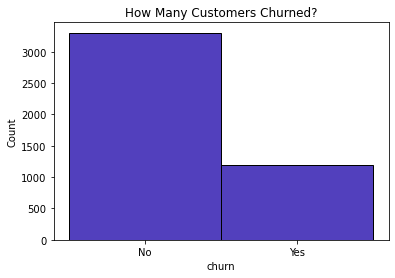

In [4]:
#Adding title:
plt.title("How Many Customers Churned?")
#drawing histogram
sns.histplot(train, x = 'churn', legend = True);

In [5]:
round((train[train.churn == 'Yes'].count().churn / train.churn.shape[0]) * 100)

27

## <font color=blue>Customers Paying With Electronic Checks Are More Likely to Churn<font>

Text(0.5, 0, 'Payment Type')

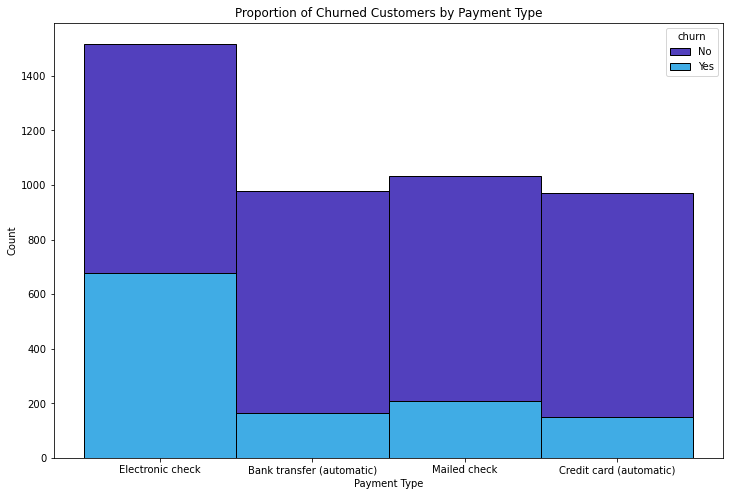

In [6]:
#Defining size of chart window for visibility:
f = plt.figure(figsize=(12,8))
#Adding a subplot such that my churn values are stacked
ax = f.add_subplot(1,1,1)

#Drawing the histogram, stacking on 'churn' variable, and huing by 'churn' variable. Including legend and title:
sns.histplot(data= train, ax=ax, stat="count", multiple="stack",
             x="payment_type", kde=False, hue="churn",
             element="bars", legend=True).set(Title = "Proportion of Churned Customers by Payment Type")
plt.xlabel('Payment Type')

#### Statistical Testing
- $H_0$: Customers paying with e-check are equally or less likely to churn.
- $H_a$: Customers paying with e-check are more likely to churn.

In [7]:
#Creating a dataframe from 'payment_type' and 'churn' columns within train subsample
e_check_hypothesis = train[['payment_type', 'churn']]
#adding a column with boolean values indicating whether the customer pays with electronic check
e_check_hypothesis['e_check_boolean'] = (train['payment_type'] == 'Electronic check')

#Creating a contingency table from a crosstabulation of churn and whether the customer pays with e-check
e_check_contingency_table = pd.crosstab(e_check_hypothesis.churn, e_check_hypothesis.e_check_boolean)

#running chi-squared analysis on churn and payment with e-checks
chi2, p, degf, expected = stats.chi2_contingency(e_check_contingency_table)

#using significance_test script from my stats_toolkit module to take p-value and return string indicating whether we can reject the null:
significance_test(p)

Sufficient evidence -> Reject the null hypothesis.


##### Conclusion:
- We can reject the null that customers paying with e-check are equally or less likely to churn. 

##### Takeaway:
- Customers paying with e-check are more likely to churn.

## <font color=blue>Customers With Multiple Phone Lines Don't Appear More Likely to Churn<font>

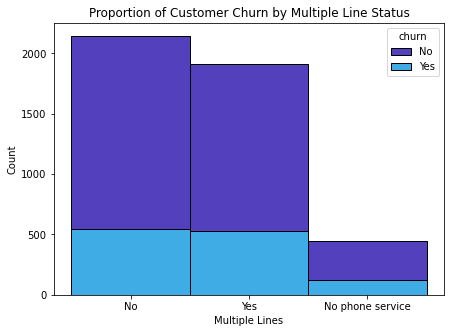

In [8]:
#Defining size of chart window for visibility:
f = plt.figure(figsize=(7,5))
#Adding a subplot such that my churn values are stacked
ax = f.add_subplot(1,1,1)

#Drawing the histogram, stacking on 'churn' variable, and huing by 'churn' variable. Including legend and title:
sns.histplot(data= train, ax=ax, stat="count", multiple="stack",
             x="multiple_lines", kde=False, hue="churn",
             element="bars", legend=True).set(Title = "Proportion of Customer Churn by Multiple Line Status")
plt.xlabel("Multiple Lines");

#### Statistical Testing
- $H_0$: Customers with multiple lines are equally or less likely to churn.
- $H_a$: Customers with multiple lines are more likely to churn.

In [9]:
#Creating a dataframe from 'multiple_lines' and 'churn' columns within train subsample:
multiple_line_hypothesis = train[['multiple_lines', 'churn']]
#adding a column with boolean values indicating whether the customer has multiple lines:
multiple_line_hypothesis['multiple_lines_boolean'] = (train['multiple_lines'] == 'Yes')

#Creating a contingency table from a crosstabulation of churn and whether the customer has multiple lines:
multi_line_contingency_table = pd.crosstab(multiple_line_hypothesis.churn, multiple_line_hypothesis.multiple_lines_boolean)

#running chi-squared analysis on churn and whether customer has multiple lines:
chi2, p, degf, expected = stats.chi2_contingency(multi_line_contingency_table)

#using significance_test script from my stats_toolkit module to take p-value and return string indicating whether we can reject the null:
significance_test(p)

Insufficient evidence -> Fail to reject the null hypothesis.


##### Conclusion:
- We cannot reject the null that customers with multiple lines are equally or less likely to churn. 

##### Takeaway:
- Current evidence does *not* indicate that customers with multiple lines are more likely to churn.

## <font color=blue>Customers With Fiber Optic Internet Are More Likely to Churn<font>

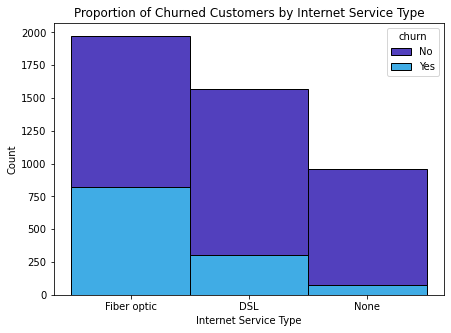

In [10]:
#Defining size of chart window for visibility:
f = plt.figure(figsize=(7,5))
#Adding a subplot such that my churn values are stacked
ax = f.add_subplot(1,1,1)

#Drawing the histogram, stacking on 'churn' variable, and huing by 'churn' variable. Including legend and title:
sns.histplot(data= train, ax=ax, stat="count", multiple="stack",
             x="internet_service_type", kde=False, hue="churn",
             element="bars", legend=True).set(Title = "Proportion of Churned Customers by Internet Service Type")
plt.xlabel('Internet Service Type');

#### Statistical Testing
- $H_0$: Customers with fiber optic internet are equally or less likely to churn.
- $H_a$: Customers with fiber optic internet are more likely to churn.

In [11]:
#Creating a dataframe from 'internet_service_type' and 'churn' columns within train subsample:
fiber_optic_hypothesis = train[['internet_service_type', 'churn']]
#adding a column with boolean values indicating whether the customer has fiber optic internet:
fiber_optic_hypothesis['fiber_optic'] = (train['internet_service_type'] == 'Fiber optic')

#Creating a contingency table from a crosstabulation of churn and whether the customer has fiber optic internet:
contingency_table = pd.crosstab(fiber_optic_hypothesis.churn, fiber_optic_hypothesis.fiber_optic)

#running chi-squared analysis on churn and whether customer has fiber optic internet:
chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

#using significance_test script from my stats_toolkit module to take p-value and return string indicating whether we can reject the null:
significance_test(p)

Sufficient evidence -> Reject the null hypothesis.


##### Conclusion:
- We can reject the null that customers with fiber optic internet are equally or less likely to churn. 

##### Takeaway:
- Customers with fiber optic internet are more likely to churn.

# Using the Best 3 Models:

## <font color=green>Baseline:<font> 

### The Baseline Model Predicts Customers Will *Not* Churn and Its Accuracy is ~73%

In [12]:
# Calculating Baseline Accuracy:
baseline_accuracy = (train[train['churn'] == 'No'].shape[0] / train.shape[0])
round(baseline_accuracy, 2)

0.73

## <font color=green>Decision Tree:<font>
- max_depth = 4

In [13]:
#Creating the object and fitting the model:
tree = DecisionTreeClassifier(max_depth=4, random_state=123)
tree = tree.fit(X_train, y_train)

### In-Sample Accuracy is ~ 78%

In [14]:
#Performance on In-Sample Data:
dt_in_sample_accuracy = tree.score(X_train, y_train)
round(dt_in_sample_accuracy, 2)

0.78

### Out-of-Sample Accuracy is ~ 80%

In [15]:
#Performance on Out-of-Sample Data:
dt_out_of_sample_accuracy = tree.score(X_validate, y_validate)
round(dt_out_of_sample_accuracy, 2)

0.81

## <font color=green>Random Forest:<font>
- min_samples_per_leaf = 10
- max_depth = 10

In [16]:
#Creating the object and fitting the model:
rf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 10, random_state = 123)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, random_state=123)

### In-Sample Accuracy is ~ 81%

In [17]:
#Performance on In-Sample Data:
rf_in_sample_accuracy = rf.score(X_train, y_train)
round(rf_in_sample_accuracy, 2)

0.81

### Out-of-Sample Accuracy is ~ 82%

In [18]:
#Performance on Out-of-Sample Data:
rf_out_of_sample_accuracy = rf.score(X_validate, y_validate)
round(rf_out_of_sample_accuracy, 2)

0.82

## <font color=green>K-Nearest Neighbors (KNN):<font>
- k = 18

In [19]:
#Creating the model object and fitting the data:
knn = KNeighborsClassifier(n_neighbors=18, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=18)

### In-Sample Accuracy is ~ 80%

In [20]:
#Performance on In-Sample Data:
knn_in_sample_accuracy = knn.score(X_train, y_train)
round(knn_in_sample_accuracy, 2)

0.8

### Out-of-Sample Accuracy is ~ 80%

In [21]:
#Performance on Out-of-Sample data:
knn_out_of_sample_accuracy = knn.score(X_validate, y_validate)
round(knn_out_of_sample_accuracy, 2)

0.8

# Testing With the Best Model:
- The accuracy of the model is determined by measuring model's performance on a dataset where the actual outcomes are known.

## Test Accuracy is ~ 82%

In [22]:
#Running the model on the 'test' set to see how we can expect it to perform on future data:
rf_test_sample_accuracy = rf.score(X_test, y_test)
round(rf_test_sample_accuracy, 2)

0.82

## Visualizing Model Performance Relative to Differing Hyperparameters:

In [23]:
metrics = []
max_depth =20

for i in range(2, max_depth):
    # Make the model (note that as n_samples goes up, max_depth will go down)
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model on the training set to determine accuracy on known data
    forest = forest.fit(X_train, y_train)

    # Evaluate model's performance on training set:
    in_sample_accuracy = forest.score(X_train, y_train)

    #Evaluate how the model performs on the validate set to compare with the training set (helps check for overfitting):
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    #creates an entry into a dictionary containing metrics for each hyperparameter combination:
    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }

    metrics.append(output)

# converting output dictionary to dataframe:    
#df = pd.DataFrame(metrics)
#Adding a 'difference' column that contains values for the difference between the model's accuracy on the train and validate sets:
#df["difference"] = df.train_accuracy - df.validate_accuracy

In [24]:
#df

In [28]:
#Using my optimal_rf_finder model to run a series of random forest models with differing hyperparameters for comparison:
df = optimal_rf_finder(X_train, y_train, X_validate, y_validate)
#Sorting models to optimize for accuracy, while ensuring model is generalizable. Showing best model.
df[df.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True]).head(1)

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
8,10,10,0.813556,0.815111,-0.001556


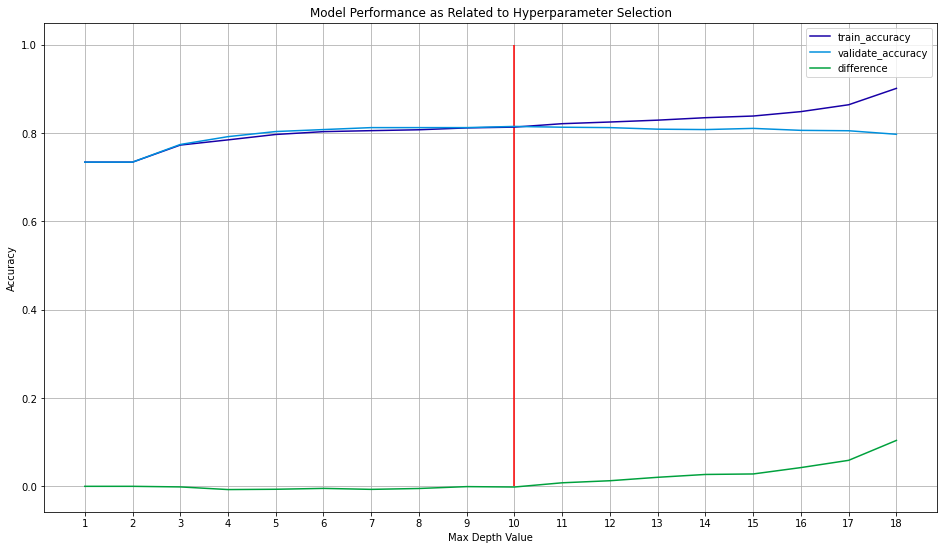

In [26]:
#Using a graph to plot the results of function built to find optimal model:
rf_performance_grapher(df)

#Adding a red line to show the most optimal hyperparameter combination for this Random Forest Model:
plt.vlines(x = 10, ymin = 0, ymax = 1, colors = 'r', linestyles = 'solid')
plt.xlabel('Max Depth Value');

#### Takeaway:
- This model is selected as the best, as I want to optimize for accuracy, while ensuring that the model generalizes to future, unknown datasets. 

# In Summary:

## Recommendations:
- Advocating for customers to sign up for a payment method other than electronic check.
- Figure out what's happening with fiber optic internet.
- I recommend that we deploy this model in the future to predict which customers are likely to churn.

## Next Steps:
- Run some more multivariate analysis to understand which features have legitimate causal relationships with churn. Understanding this better may help improve model's performance. 
- Gather data on customer satisfaction, particularly with services like fiber optic internet. This may help understand why having these services seem to indicate a customer will churn.
- I would like to dive into investigating what the issue seems to be with fiber. 

# Sending the predictions to a CSV:

In [27]:
y_predictions = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)

#Creating empty DataFrame:
predictions = pd.DataFrame()
#Creating customer_id column:
predictions['customer_id'] = test.customer_id
#Creating prediction column:
predictions['prediction'] = y_predictions
#Creating probability column:
predictions['probability'] = y_proba[:,1]

predictions.to_csv("predictions.csv")